Compare sky fluxes generated from `feasibgs.forwardmodel.py` to sky fluxes from Parker

In [1]:
import os
import h5py
import numpy as np
import astropy.units as u
# -- local -- 
import env
from feasibgs import util as UT
from feasibgs import catalogs as Cat
from feasibgs import forwardmodel as FM

In [14]:
import desisim.simexp
import specsim.atmosphere

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as pl 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

read in sky fluxes from Parker

In [3]:
dark_sky = np.loadtxt(UT.dat_dir()+'sky/spec-sky.dat', unpack=True, skiprows=2, usecols=[0,1])

f = UT.dat_dir()+'sky/moon_sky_spectrum.hdf5'
assert os.path.isfile(f)
f_hdf5 = h5py.File(f, 'r')
ws, ss = [], [] 
for i in range(4): 
    ws.append(f_hdf5['sky'+str(i)+'/wave'].value)
    ss.append(f_hdf5['sky'+str(i)+'/sky'].value)
    
bright_sky0 = [10.*ws[2], ss[2]]
bright_sky1 = [10.*ws[3], ss[3]]

(0.5, 100)

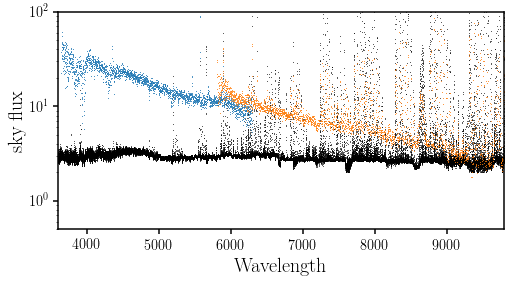

In [4]:
fig = plt.figure(figsize=(8,4))
sub = fig.add_subplot(111)
sub.scatter(dark_sky[0], dark_sky[1], c='k', lw=0, s=0.5)
sub.scatter(bright_sky0[0], bright_sky0[1], lw=0, s=1.)
sub.scatter(bright_sky1[0], bright_sky1[1], lw=0, s=1.)
sub.set_xlabel('Wavelength', fontsize=20)
sub.set_xlim([3600., 9800.])
sub.set_ylabel('sky flux', fontsize=20)
sub.set_yscale("log")
sub.set_ylim([0.5, 100])

read in catalog data

In [5]:
cata = Cat.GamaLegacy()
gleg = cata.Read()

redshift = gleg['gama-spec']['z_helio']  # redshift
absmag_ugriz = cata.AbsMag(gleg, kcorr=0.1, H0=70, Om0=0.3) # ABSMAG k-correct to z=0.1

# BGS templates
bgs3 = FM.BGStree()
bgstemp = FM.BGStemplates(wavemin=1500.0, wavemax=2e4)
mabs_temp = bgs3.meta['SDSS_UGRIZ_ABSMAG_Z01'] # template absolute magnitude

# pick a random galaxy from the GAMA-legacy sample and then
# find the closest template
i_rand = [1765]# np.random.choice(range(absmag_ugriz.shape[1]), size=1)

# meta data of [z, M_r0.1, 0.1(g-r)]
gleg_meta = np.vstack([
    redshift[i_rand],
    absmag_ugriz[2,i_rand],
    absmag_ugriz[1,i_rand] - absmag_ugriz[2,i_rand]]).T
match, _ = bgs3.Query(gleg_meta)

# velocity dispersion
vdisp = np.repeat(100.0, len(i_rand)) # [km/s]

flux, wave, meta = bgstemp.Spectra(
    gleg['gama-photo']['modelmag_r'][i_rand],
    redshift[i_rand],
    vdisp,
    seed=1, templateid=match, silent=False)

INFO:io.py:1015:read_basis_templates: Reading /Volumes/chang_eHDD/projects/desi/spectro/templates/basis_templates/v2.3/bgs_templates_v2.1.fits metadata.


/Users/chang/projects/feasiBGS/feasibgs/catalogs.py:197: RuntimeWarning: divide by zero encountered in log10
  DM = 5. * np.log10(1e5*D_L)
/Users/chang/projects/feasiBGS/feasibgs/catalogs.py:197: RuntimeWarning: invalid value encountered in log10
  DM = 5. * np.log10(1e5*D_L)


INFO:io.py:1027:read_basis_templates: Reading /Volumes/chang_eHDD/projects/desi/spectro/templates/basis_templates/v2.3/bgs_templates_v2.1.fits
DEBUG:templates.py:359:_blurmatrix: Populating blur matrix with 1 unique velocity dispersion values.


In [6]:
def skyFlux(obvscond): 
    '''
    '''
    waves, fluxes, skyfluxes = bgstemp._skyflux(wave, flux, skyerr=1., **obvscond)
    return waves, skyfluxes

In [8]:
ws, fskys = skyFlux({'airmass': 1.0, 'moonalt': -60., 'moonsep': 180, 'moonfrac':0.0, 'seeing':1.1})

('config', <specsim.config.Node object at 0x10bc93c90>)
DEBUG:simexp.py:659:get_source_types: bgs 1 targets


(0.5, 10)

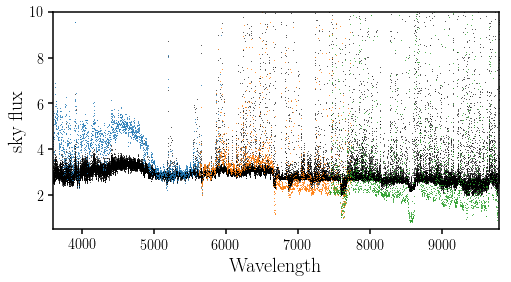

In [13]:
fig = plt.figure(figsize=(8,4))
sub = fig.add_subplot(111)
sub.scatter(dark_sky[0], dark_sky[1], c='k', lw=0, s=0.5)
for i in range(len(ws)):
    sub.scatter(ws[i], 1.9067*fskys[i], lw=0, s=1)
sub.set_xlabel('Wavelength', fontsize=20)
sub.set_xlim([3600., 9800.])
sub.set_ylabel('sky flux', fontsize=20)
#sub.set_yscale("log")
sub.set_ylim([0.5, 10])

In [16]:
config = desisim.simexp._specsim_config_for_wave((dark_sky[0][dark_sky[0] < 9800]*u.Angstrom).to('Angstrom').value, 
                                                 dwave_out=None, specsim_config_file='desi')
atmosphere = specsim.atmosphere.initialize(config)

In [17]:
atmosphere.surface_brightness

<Quantity [0.9360106 , 1.09703289, 1.37479084, ..., 2.64797586, 1.27430525,
           0.7928738 ] 1e-17 erg / (Angstrom arcsec2 cm2 s)>

(0.5, 10)

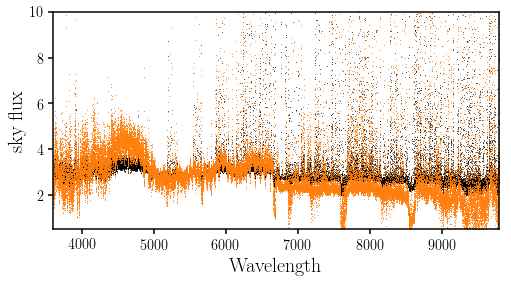

In [24]:
fig = plt.figure(figsize=(8,4))
sub = fig.add_subplot(111)
sub.scatter(dark_sky[0], dark_sky[1], c='k', lw=0, s=0.5)
sub.scatter(config.wavelength, atmosphere._moon.surface_brightness * 1.9067, lw=0, s=1)
sub.scatter(config.wavelength, atmosphere.surface_brightness * np.pi, lw=0, s=1)
sub.set_xlabel('Wavelength', fontsize=20)
sub.set_xlim([3600., 9800.])
sub.set_ylabel('sky flux', fontsize=20)
#sub.set_yscale("log")
sub.set_ylim([0.5, 10])